<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy.xlsx'
file_path = 'datos_finales_tommy.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
print(df.head())

        DATE Microcycle  Injury preseason-season      TD    HSR  +25 Km/h  \
0 2021-08-12        M-2       0           SEASON  1268.0    0.0         0   
1 2021-08-13        M-1       0           SEASON  4135.0  112.0         2   
2 2021-08-15        M+1       0           SEASON  6379.0   86.0         0   
3 2021-08-17        M-4       0           SEASON  6287.0  209.0         9   
4 2021-08-18        M-3       0           SEASON  6543.0  166.0         9   

    ACC   DEC  PlayerID  ...   TD_MSWR  HSR_ACWR  HSR_MSWR  +25 Km/h_ACWR  \
0  11.0   5.0     23085  ...  5.217107  1.000000  1.923701       1.000000   
1  47.0  20.0     23085  ...  1.508831  1.000000  0.974045       1.000000   
2  49.0  48.0     23085  ...  1.207543  1.000000  0.832277       1.000000   
3  62.0  44.0     23085  ...  1.140383  1.000000  0.757251       1.000000   
4  39.0  35.0     23085  ...  1.140354  0.924272  0.762941       0.545055   

   +25 Km/h_MSWR  ACC_ACWR  ACC_MSWR  DEC_ACWR   DEC_MSWR  Injury_7_day  


Chequear desbalanceo de clases

In [3]:
print("No Lesión: " + str(df[df["Injury_7_day"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury_7_day"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury_7_day'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 6297
Lesión: 253
Porcentaje de lesionados en el dataset: 3.86%


## Initialize metrics

In [ ]:
metrics = ['ACC', 'HSR', 'TD', '+25 Km/h', 'Sprints',
       'Mins']

metrics_den = ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins']

metrics_rel = ['TD_Rel',
       'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel']

metrics_den_3 = ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3']

metrics_den_7 = ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7']

metrics_den_rel_3 = ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD_Rel',
       'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3']

metrics_den_rel_7 = ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD_Rel',
       'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7']

metrics_3 = ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3']

metrics_7 = ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7']

metrics_rel_3 = ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD_Rel',
       'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3']

metrics_rel_7 = ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD_Rel',
       'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7']

In [ ]:
metrics_sets = {
    "metrics_den_3": ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3'],
    "metrics_den_7": ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7'],
    "metrics_den_rel_3": ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3'],
    "metrics_den_rel_7": ['TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'Sprints/Mins', '% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7'],
    "metrics_3": ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3'],
    "metrics_7": ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7'],
    "metrics_rel_3": ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'Sprints-3'],
    "metrics_rel_7": ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', '% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'Sprints_Rel','TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'Sprints-7']
}

metrics_standarize = ['TD', 'HSR', '+25 Km/h', 'ACC', 'DEC', 'Max Speed', 'Sprints', 'Max Speed Season',
       'Avg Speed Season', '% Max Speed', 'Speed Diff Max Avg', 'TD_Rel',
       'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel', 'DEC_Rel', 'Sprints_Rel',
       'TD/Mins', 'HSR/Mins', '+25 Km/h/Mins', 'ACC/Mins', 'DEC/Mins',
       'Sprints/Mins', 'TD_max', 'TD_avg', 'HSR_max', 'HSR_avg',
       '+25 Km/h_max', '+25 Km/h_avg', 'ACC_max', 'ACC_avg', 'DEC_max',
       'DEC_avg', 'Sprints_max', 'Sprints_avg', 'TD/Mins_max', 'TD/Mins_avg',
       'HSR/Mins_max', 'HSR/Mins_avg', '+25 Km/h/Mins_max',
       '+25 Km/h/Mins_avg', 'ACC/Mins_max', 'ACC/Mins_avg', 'Sprints/Mins_max',
       'Sprints/Mins_avg', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', 'HSR-21', '+25 Km/h-21', 'ACC-21', 'DEC-21',
       'Sprints-21']

# Correlation of variables

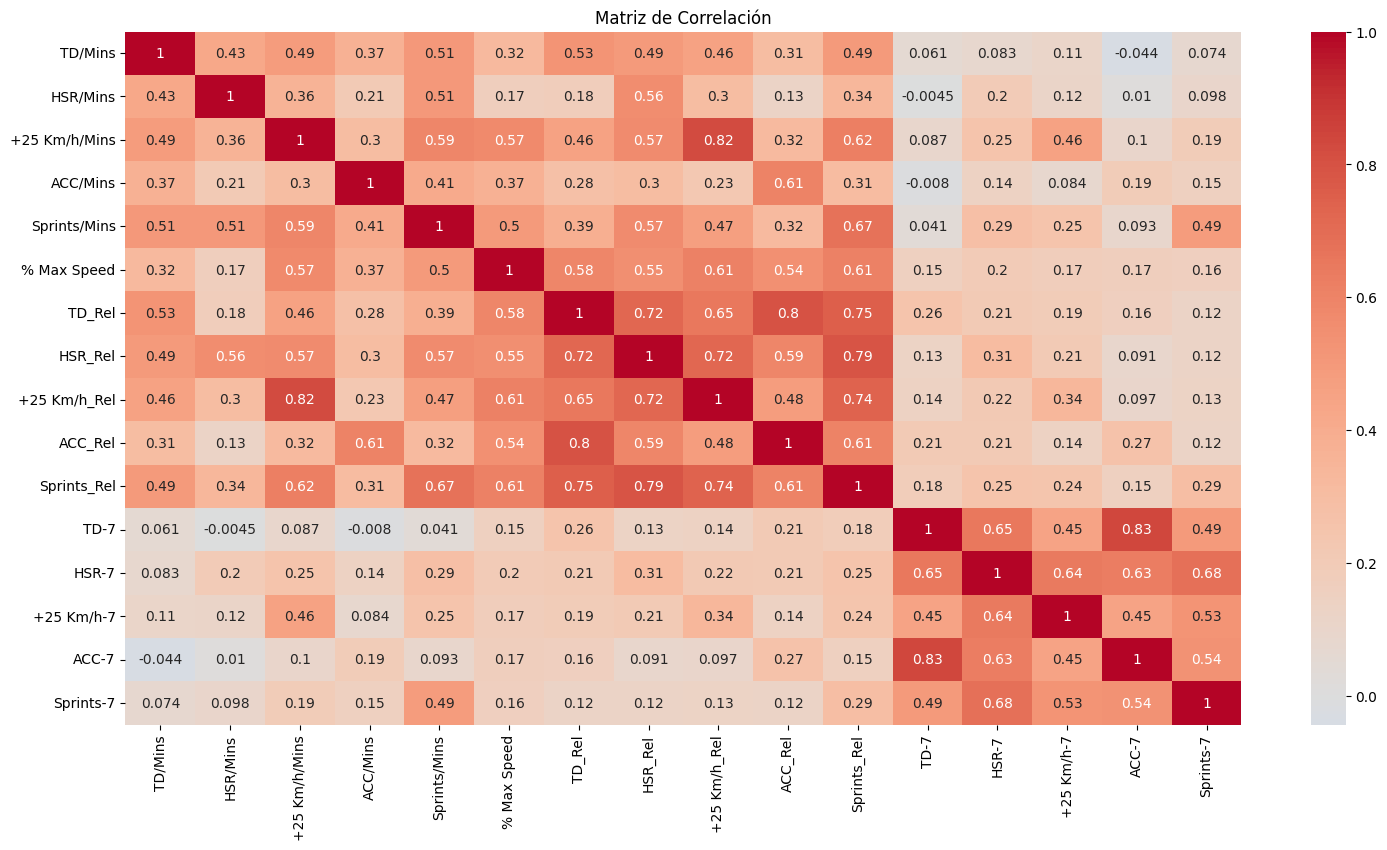

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df[metrics_den_rel_7].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_with_constant = add_constant(df[metrics_den_rel_3])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

MissingDataError: exog contains inf or nans

# ML Modelos

## Separate data into X, y and player_ids

In [4]:
metrics = ['TD', 'HSR',
       '+25 Km/h', 'ACC', 'DEC', 'Max Speed', 'Sprints', 'Mins','% Max Speed',
       'Speed Diff Max Avg', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel',
       'DEC_Rel', 'TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
       '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
       'Sprints-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR',
       '+25 Km/h_ACWR', '+25 Km/h_MSWR', 'ACC_ACWR', 'DEC_ACWR']

In [5]:
player_ids = df['PlayerID']
X = df[metrics]
y = df['Injury_7_day']

## Do TPOT Classifier

In [7]:
X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(X, y, player_ids, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [8]:
X_train.shape

(10076, 34)

In [ ]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Mejor pipeline
print(tpot.fitted_pipeline_)

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9691344676828548

Generation 2 - Current best internal CV score: 0.9723119264248297

Generation 3 - Current best internal CV score: 0.9866018255937611

Generation 4 - Current best internal CV score: 0.9866018255937611

Generation 5 - Current best internal CV score: 0.9866018255937611

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=2, min_samples_split=9, n_estimators=100)
Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.4, min_samples_leaf=2,
                                      min_samples_split=9, random_state=42))])


## Iterate XGBoost to find best parameters and metrics

SMOTE Technique

In [6]:
# Split the data into training and test sets (test set remains untouched)
X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(X, y, player_ids, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury_7_day
0    5038
1    5038
Name: count, dtype: int64
Injury_7_day
0    5038
1    5038
Name: count, dtype: int64


In [9]:
# Base parameters from the document
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.9,
    'eval_metric': 'error',
    'alpha': 5,
    'gamma': 5
}

# Parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.07, 0.09, 0.1],
    'max_depth': [3, 4, 5],+
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [8, 9, 10]  # Different class weights to test
}

# Stratified K-Fold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model with base parameters
model = XGBClassifier(**base_params)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Use ROC-AUC for evaluation
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print the best results
print(f"Best ROC-AUC: {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best ROC-AUC: 0.9883
Best Parameters: {'learning_rate': 0.09, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 10}


## Transform test data

In [22]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
player_ids_test = player_ids_test.reset_index(drop=True)
print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))
print("Length of player_ids_test:", len(player_ids_test))

Length of X_test: 1310
Length of y_test: 1310
Length of player_ids_test: 1310


Map to the same variable names as the ML was trained

In [ ]:
# # Define mappings for test feature renaming
# test_to_train_mapping_max = {
#     'TD/Mins_max': 'TD/Mins',
#     'HSR/Mins_max': 'HSR/Mins',
#     '+25 Km/h/Mins_max': '+25 Km/h/Mins',
#     'ACC/Mins_max': 'ACC/Mins',
#     'Sprints/Mins_max': 'Sprints/Mins'
# }

# test_to_train_mapping_avg = {
#     'TD/Mins_avg': 'TD/Mins',
#     'HSR/Mins_avg': 'HSR/Mins',
#     '+25 Km/h/Mins_avg': '+25 Km/h/Mins',
#     'ACC/Mins_avg': 'ACC/Mins',
#     'Sprints/Mins_avg': 'Sprints/Mins'
# }

# #X_test_final_scaled = X_test_final_scaled.rename(columns=test_to_train_mapping_max)
# X_test_max = X_test_max.rename(columns=test_to_train_mapping_max)
# X_test_avg = X_test_avg.rename(columns=test_to_train_mapping_avg)

In [23]:
# Test set evaluation
y_test_probs = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_probs)

# y_test_probs_max = best_model.predict_proba(X_test_max)[:, 1]
# test_roc_auc_max = roc_auc_score(y_test, y_test_probs_max)


# y_test_probs_avg = best_model.predict_proba(X_test_avg)[:, 1]
# test_roc_auc_avg = roc_auc_score(y_test, y_test_probs_avg)


print(f"Test ROC-AUC Max: {test_roc_auc:.4f}")

# print(f"Test ROC-AUC Max: {test_roc_auc_max:.4f}")

# print(f"Test ROC-AUC Avg: {test_roc_auc_avg:.4f}")

Test ROC-AUC Max: 0.6553


In [24]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

In [25]:
# # Rename columns
# X_test_max = X_test_max.rename(columns=test_to_train_mapping_max)
# X_test_avg = X_test_avg.rename(columns=test_to_train_mapping_avg)

# Predict probabilities for max and avg test sets
probs = best_model.predict_proba(X_test)
# probs_max = best_model.predict_proba(X_test_max)
# probs_avg = best_model.predict_proba(X_test_avg)

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = probs[:, 1] * 100
# injury_risk_percentage_max = probs_max[:, 1] * 100
# injury_risk_percentage_avg = probs_avg[:, 1] * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]
# risk_levels_max = [categorize_risk(percentage) for percentage in injury_risk_percentage_max]
# risk_levels_avg = [categorize_risk(percentage) for percentage in injury_risk_percentage_avg]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': player_ids_test,  # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test)  # Add only relevant max metrics

# # Create the `results_max` DataFrame with only relevant metrics and calculated values
# results_max = pd.DataFrame({
#     'Player_ID': player_ids_test,  # Add player IDs
#     'Actual_Label': y_test,  # Add actual labels
#     '%': injury_risk_percentage_max,
#     'Risk_Level': risk_levels_max
# }).join(X_test_max)  # Add only relevant max metrics

# # Create the `results_avg` DataFrame with only relevant metrics and calculated values
# results_avg = pd.DataFrame({
#     'Player_ID': player_ids_test,
#     'Actual_Label': y_test,  # Add actual labels
#     '%': injury_risk_percentage_avg,
#     'Risk_Level': risk_levels_avg
# }).join(X_test_avg)  # Add only relevant avg metrics



In [28]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

file_path_combined = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# # Write `results_max` to another sheet
# ws_max = wb.create_sheet(title="Max Injury Risk Results")
# for r_idx, row in enumerate(dataframe_to_rows(results_max, index=True, header=True), start=1):
#     for c_idx, value in enumerate(row, start=1):
#         ws_max.cell(row=r_idx, column=c_idx, value=value)

# # Conditional formatting for `results_max`
# risk_level_max_col_idx = list(results_max.columns).index("Risk_Level") + 2
# for row in ws_max.iter_rows(min_row=2, max_row=ws_max.max_row, min_col=risk_level_max_col_idx, max_col=risk_level_max_col_idx):
#     for cell in row:
#         risk_level = cell.value
#         if risk_level in color_mapping:
#             cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# # Write `results_avg` to another sheet
# ws_avg = wb.create_sheet(title="Avg Injury Risk Results")
# for r_idx, row in enumerate(dataframe_to_rows(results_avg, index=True, header=True), start=1):
#     for c_idx, value in enumerate(row, start=1):
#         ws_avg.cell(row=r_idx, column=c_idx, value=value)

# # Conditional formatting for `results_avg`
# risk_level_avg_col_idx = list(results_avg.columns).index("Risk_Level") + 2
# for row in ws_avg.iter_rows(min_row=2, max_row=ws_avg.max_row, min_col=risk_level_avg_col_idx, max_col=risk_level_avg_col_idx):
#     for cell in row:
#         risk_level = cell.value
#         if risk_level in color_mapping:
#             cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_combined)

## Feature Engineering

## Select X and Y

In [ ]:
metrics_train = ['TD', 'HSR', '+25 Km/h', 'ACC', 'Sprints', 'Max Speed', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3']
max_metrics_test = ['TD_max', 'HSR_max', '+25 Km/h_max', 'ACC_max', 'Sprints_max', 'Max Speed Season', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3']

avg_metrics_test = ['TD_avg', 'HSR_avg', '+25 Km/h_avg', 'ACC_avg', 'Sprints_avg', 'Avg Speed Season', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3']

player_ids = df['PlayerID']
X = df
y = df['Injury']

## Split data into training and testing

In [ ]:
X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(
    X, y, player_ids, test_size=0.3, random_state=42, stratify=y
)

# Extract training and testing subsets for the respective metrics
X_train = X_train[metrics_train]
X_test_max = X_test[max_metrics_test]
X_test_avg = X_test[avg_metrics_test]

# Reset index for player_ids_test
player_ids_test = player_ids_test.reset_index(drop=True)

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Define mappings for test feature renaming
test_to_train_mapping_max = {
    'TD_max': 'TD',
    'HSR_max': 'HSR',
    '+25 Km/h_max': '+25 Km/h',
    'ACC_max': 'ACC',
    'Sprints_max': 'Sprints',
    'Max Speed Season': 'Max Speed',
    'TD-3': 'TD-3',
    'HSR-3': 'HSR-3',
    '+25 Km/h-3': '+25 Km/h-3',
    'ACC-3': 'ACC-3',
}

test_to_train_mapping_avg = {
    'TD_avg': 'TD',
    'HSR_avg': 'HSR',
    '+25 Km/h_avg': '+25 Km/h',
    'ACC_avg': 'ACC',
    'Sprints_avg': 'Sprints',
    'Avg Speed Season': 'Max Speed',
    'TD-3': 'TD-3',
    'HSR-3': 'HSR-3',
    '+25 Km/h-3': '+25 Km/h-3',
    'ACC-3': 'ACC-3',
}

# Define stratified cross-validation
n_splits = 5
strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage for metrics
log_loss_max = []
log_loss_avg = []
roc_auc_max = []
roc_auc_avg = []

# Compute class imbalance weight
class_counts = y.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

# Stratified Cross-Validation
for train_idx, val_idx in strat_kfold.split(X, y):
    # Train-validation split
    X_train = X.iloc[train_idx][metrics_train]
    X_val = X.iloc[val_idx][metrics_train]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]

    # Test datasets for the current validation fold
    X_test_max = X.iloc[val_idx][max_metrics_test].rename(columns=test_to_train_mapping_max)
    X_test_avg = X.iloc[val_idx][avg_metrics_test].rename(columns=test_to_train_mapping_avg)

    # Reset index for consistency
    X_test_max = X_test_max.reset_index(drop=True)
    X_test_avg = X_test_avg.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_max_scaled = scaler.transform(X_test_max)
    X_test_avg_scaled = scaler.transform(X_test_avg)

    # Train the XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False
    )
    xgb_model.fit(X_train_scaled, y_train)

    # Predict probabilities for validation set and both test sets
    y_val_proba = xgb_model.predict_proba(X_val_scaled)
    y_test_max_proba = xgb_model.predict_proba(X_test_max_scaled)
    y_test_avg_proba = xgb_model.predict_proba(X_test_avg_scaled)

    # Ensure `y_val` is a 1D array of labels
    y_val = np.array(y_val).ravel()  # Flatten to 1D if it is in DataFrame format

    # Debug: Check shapes of y_val and predicted probabilities
    print(f"Shape of y_val: {y_val.shape}")  # Should be (n_samples,)
    print(f"Shape of y_val_proba: {y_val_proba.shape}")  # Should be (n_samples, n_classes)

    # For binary classification, no need to binarize labels
    # Directly use `y_val` and `y_val_proba` in `roc_auc_score`

    # Evaluate metrics
    # Log-loss
    log_loss_val = log_loss(y_val, y_val_proba)
    log_loss_test_max = log_loss(y_val, y_test_max_proba)
    log_loss_test_avg = log_loss(y_val, y_test_avg_proba)

    # ROC-AUC (no need for binarization in binary classification)
    roc_auc_val = roc_auc_score(y_val, y_val_proba[:, 1])  # Use probabilities for class 1
    roc_auc_test_max = roc_auc_score(y_val, y_test_max_proba[:, 1])  # Use probabilities for class 1
    roc_auc_test_avg = roc_auc_score(y_val, y_test_avg_proba[:, 1])  # Use probabilities for class 1

    # Append metrics for this fold
    log_loss_max.append(log_loss_test_max)
    log_loss_avg.append(log_loss_test_avg)
    roc_auc_max.append(roc_auc_test_max)
    roc_auc_avg.append(roc_auc_test_avg)

# Output average metrics across folds
print(f"Log-Loss (Max Metrics Test): {np.mean(log_loss_max):.4f} ± {np.std(log_loss_max):.4f}")
print(f"Log-Loss (Avg Metrics Test): {np.mean(log_loss_avg):.4f} ± {np.std(log_loss_avg):.4f}")
print(f"ROC-AUC (Max Metrics Test): {np.mean(roc_auc_max):.4f} ± {np.std(roc_auc_max):.4f}")
print(f"ROC-AUC (Avg Metrics Test): {np.mean(roc_auc_avg):.4f} ± {np.std(roc_auc_avg):.4f}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:32:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Shape of y_val: (187,)
Shape of y_val_proba: (187, 2)
Shape of y_val: (187,)
Shape of y_val_proba: (187, 2)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:32:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:32:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Shape of y_val: (187,)
Shape of y_val_proba: (187, 2)
Shape of y_val: (187,)
Shape of y_val_proba: (187, 2)
Shape of y_val: (187,)
Shape of y_val_proba: (187, 2)
Log-Loss (Max Metrics Test): 0.3367 ± 0.0174
Log-Loss (Avg Metrics Test): 0.4068 ± 0.0268
ROC-AUC (Max Metrics Test): 0.4981 ± 0.0612
ROC-AUC (Avg Metrics Test): 0.4372 ± 0.0089


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:32:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Apply SMOTE only to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Standarize the data

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_max = scaler.transform(np.array(X_test_max))
X_test_avg = scaler.transform(np.array(X_test_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Train XGBoost

In [ ]:
# Train the XGBoost model
# Using scale_pos_weight to handle class imbalance
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # Apply the weight for Class 1
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:34:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

https://www.kaggle.com/code/chandrimad31/ieee-competition-predicting-fraud-with-lightgbm?scriptVersionId=35702506

## Define a function to categorize the risk levels based on the percentage

In [ ]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Predict avg and max

In [ ]:
# Predict probabilities for max and avg test sets
probs_max = xgb_model.predict_proba(X_test_max)
probs_avg = xgb_model.predict_proba(X_test_avg)

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage_max = probs_max[:, 1] * 100
injury_risk_percentage_avg = probs_avg[:, 1] * 100

# Categorize the injury risk percentages
risk_levels_max = [categorize_risk(percentage) for percentage in injury_risk_percentage_max]
risk_levels_avg = [categorize_risk(percentage) for percentage in injury_risk_percentage_avg]

# Create a copy of the original test set
results = X_test.copy()  # Keep original features

# Add result columns for `max`
results['%_max'] = injury_risk_percentage_max
results['Risk_Level_max'] = risk_levels_max

# Add result columns for `avg`
results['%_avg'] = injury_risk_percentage_avg
results['Risk_Level_avg'] = risk_levels_avg

# View the results
print(results.head())


          DATE  Microcycle  Injury    TD  HSR  +25 Km/h   ACC   DEC  PlayerID  \
851 2022-09-27         M-5       0  6584  106        19  92.0  61.0     77765   
217 2022-12-15         M-2       0  2564   53        13  10.0   0.0     17316   
344 2022-08-17         M+1       0  2335   77         1  21.0   9.0     21079   
282 2023-01-28  MD (AWAY)        0  9603  460       181  83.0  70.0     18096   
231 2023-01-02  MD (AWAY)        1  3259   95        13  31.0  27.0     17316   

     Max Speed  ...     TD/Mins  HSR/Mins  +25 Km/h/Mins  ACC/Mins  DEC/Mins  \
851      29.18  ...   84.627249  1.362468       0.244216  1.182519  0.784062   
217      29.09  ...   85.267709  1.762554       0.432325  0.332557  0.000000   
344      25.31  ...   57.258460  1.888180       0.024522  0.514958  0.220696   
282      33.89  ...   97.275122  4.659643       1.833468  0.840762  0.709076   
231      30.28  ...  115.978648  3.380783       0.462633  1.103203  0.960854   

     Sprints/Mins      %_max  Ri

In [ ]:
max_metrics = ['PlayerID', 'Injury', 'TD', 'HSR', '+25 Km/h', 'ACC', 'DEC','TD_max', 'HSR_max', '+25 Km/h_max', 'ACC_max', 'Sprints_max', 'Max Speed', 'Max Speed Season', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3']

avg_metrics = ['PlayerID', 'Injury', 'TD', 'HSR', '+25 Km/h', 'ACC', 'DEC','TD_avg', 'HSR_avg', '+25 Km/h_avg', 'ACC_avg', 'Sprints_avg', 'Max Speed', 'Max Speed Season', 'TD-3', 'HSR-3', '+25 Km/h-3', 'ACC-3']

In [ ]:
 # Predict probabilities for max and avg test sets
probs_max = xgb_model.predict_proba(X_test_max)
probs_avg = xgb_model.predict_proba(X_test_avg)

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage_max = probs_max[:, 1] * 100
injury_risk_percentage_avg = probs_avg[:, 1] * 100

# Categorize the injury risk percentages
risk_levels_max = [categorize_risk(percentage) for percentage in injury_risk_percentage_max]
risk_levels_avg = [categorize_risk(percentage) for percentage in injury_risk_percentage_avg]

# Include the labels (y_test) for both results
y_test_reset = y_test.reset_index(drop=True)

# Create the `results_max` DataFrame with only relevant metrics and calculated values
results_max = pd.DataFrame({
    'Player_ID': player_ids_test,
    'Actual_Label': y_test_reset,  # Add actual labels
    '%': injury_risk_percentage_max,
    'Risk_Level': risk_levels_max
}).join(X_test[max_metrics_test].reset_index(drop=True))  # Add only relevant max metrics

# Create the `results_avg` DataFrame with only relevant metrics and calculated values
results_avg = pd.DataFrame({
    'Player_ID': player_ids_test,
    'Actual_Label': y_test_reset,  # Add actual labels
    '%': injury_risk_percentage_avg,
    'Risk_Level': risk_levels_avg
}).join(X_test[avg_metrics_test].reset_index(drop=True))  # Add only relevant avg metrics

## Save the file & do color for high medium and low risk

In [ ]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

file_path_combined = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'

wb = Workbook()

# Write `results_max` to a sheet
ws_max = wb.active
ws_max.title = "Max Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results_max, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws_max.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results_max`
risk_level_max_col_idx = list(results_max.columns).index("Risk_Level") + 2
for row in ws_max.iter_rows(min_row=2, max_row=ws_max.max_row, min_col=risk_level_max_col_idx, max_col=risk_level_max_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Write `results_avg` to another sheet
ws_avg = wb.create_sheet(title="Avg Injury Risk Results")
for r_idx, row in enumerate(dataframe_to_rows(results_avg, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws_avg.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results_avg`
risk_level_avg_col_idx = list(results_avg.columns).index("Risk_Level") + 2
for row in ws_avg.iter_rows(min_row=2, max_row=ws_avg.max_row, min_col=risk_level_avg_col_idx, max_col=risk_level_avg_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_combined)
